### Purpose
1. figure out how to set number of classes from simple example (inclusive of background??)
    - dls.c excludes background!!
2. how to extract bbox predictions from RetinaNet model output?
    - raw model output of RetinaNet can't work well with fastai2 framework (e.g. get_preds method)
3. how to run inference mode from learner??
    - learn.get_preds(dl = [(x, y)]) / learner.get_preds(n_batch = bs)
    - by default, learner.get_preds run inference on all data points in valid_ds
    - [reference](https://docs.fast.ai/basic_train.html#Learner.get_preds)

### Reference
1. [06_Object_Detection.ipynb](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/06_Object_Detection.ipynb)

In [31]:
from fastai2.vision.all import *
import warnings 
warnings.filterwarnings("ignore")

path = untar_data(URLs.PASCAL_2007)

#### 1. Inspect train.json

In [32]:
path.ls()

(#8) [Path('/userhome/34/h3509807/.fastai/data/pascal_2007/test.json'),Path('/userhome/34/h3509807/.fastai/data/pascal_2007/train'),Path('/userhome/34/h3509807/.fastai/data/pascal_2007/valid.json'),Path('/userhome/34/h3509807/.fastai/data/pascal_2007/test.csv'),Path('/userhome/34/h3509807/.fastai/data/pascal_2007/test'),Path('/userhome/34/h3509807/.fastai/data/pascal_2007/train.csv'),Path('/userhome/34/h3509807/.fastai/data/pascal_2007/segmentation'),Path('/userhome/34/h3509807/.fastai/data/pascal_2007/train.json')]

In [33]:
import json

inp = json.load(open(path / 'train.json', 'r'))

In [34]:
inp.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [35]:
len(inp['categories'])

20

#### 2. Get DataBlock

In [36]:
imgs, lbl_bbox = get_annotations(path / 'train.json')
imgs[0], lbl_bbox[0]

('000012.jpg', ([[155, 96, 351, 270]], ['car']))

In [49]:
img2bbox = dict(zip(imgs, lbl_bbox))

In [50]:
getters = [lambda o: path/'train'/o, 
           lambda o: img2bbox[o][0], 
           lambda o: img2bbox[o][1]]

In [51]:
item_tfms = [Resize(224)]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

In [52]:
def get_train_imgs(noop):  return imgs

In [53]:
pascal = DataBlock(blocks = (ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter = RandomSplitter(),
                 get_items = get_train_imgs, 
                 getters = getters,
                 item_tfms = item_tfms,
                 batch_tfms = batch_tfms,
                 n_inp = 1)

In [54]:
dls = pascal.dataloaders(path / 'train')

#### 2a. Find the number of Classes

In [57]:
train_items = dls.train.items

In [61]:
# find unique classes in training set
cls_set = []
for item in train_items:
    cls_ls = img2bbox[item][1]
    cls_set.extend(cls_ls)
cls_set = set(cls_set)
len(cls_set)

20

In [63]:
get_c(dls)

4

In [64]:
dls.c = 20
get_c(dls)

20

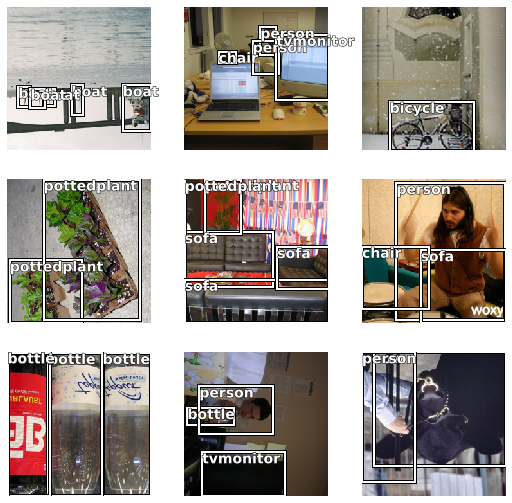

In [65]:
dls.show_batch()

#### 3. Create Model and Learner

In [66]:
import os
import sys
m_path = os.path.join(os.getcwd(), '..')
sys.path.append(m_path)

from ext_imports import *

In [67]:
encoder = create_body(resnet34, pretrained = True)
get_c(dls)

20

In [68]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)

In [69]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

In [70]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

In [71]:
def _retinanet_split(m): 
    return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [72]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

#### 4. Check Model can do Inference (on Validation Set)

In [73]:
learn.get_preds()

TypeError: object of type 'int' has no len()

In [82]:
RetinaNetFocalLoss??

In [80]:
b = dls.one_batch()

with torch.no_grad():
    out = learn.model(b[0])
out[0].shape, out[1].shape

(torch.Size([64, 35901, 20]), torch.Size([64, 35901, 4]))

In [81]:
out[2]

[[28, 28], [56, 56], [7, 7], [4, 4], [2, 2]]